### Exercise

Perform your own study of scaling laws for MNIST.

- Write a script to train a small CNN on MNIST, or find one you have written previously.
- Training for a single epoch only, vary the model size and dataset size. For the model size, multiply the width by powers of sqrt(2) (rounding if necessary - the idea is to vary the amount of compute used per forward pass by powers of 2). For the dataset size, multiply the fraction of the full dataset used by powers of 2 (i.e. 1, 1/2, 1/4, ...). To reduce noise, use a few random seeds and always use the full validation set.
- The learning rate will need to vary with model size. Either tune it carefully for each model size, or use the rule of thumb that for Adam, the learning rate should be proportional to the initialization scale, i.e. 1/sqrt(fan_in) for the standard Kaiming He initialization (which is what PyTorch generally uses by default).
- Plot the amount of compute used (on a log scale) against validation loss. The compute-efficient frontier should follow an approximate power law (straight line on a log scale).
- How does validation accuracy behave?
- Study how the compute-efficient model size varies with compute. This should also follow an approximate power law. Try to estimate its exponent.
- Repeat your entire experiment with 20% dropout to see how this affects the scaling exponents.

In [99]:
import torch as t
import torchvision
import matplotlib.pyplot as plt
import einops
from torch import nn
from torch.nn import functional as F

### Load data

In [88]:
# import data
batch_size = 1

train_loader = t.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download=True,
         transform = torchvision.transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = t.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True,
         transform = torchvision.transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

### Display images

In [94]:
train_enumerate = enumerate(train_loader)
images = []
labels = []
for i in range(32):
    _, data = next(enumerate(train_loader))
    images.append(data[0][0])
    labels.append(data[1])

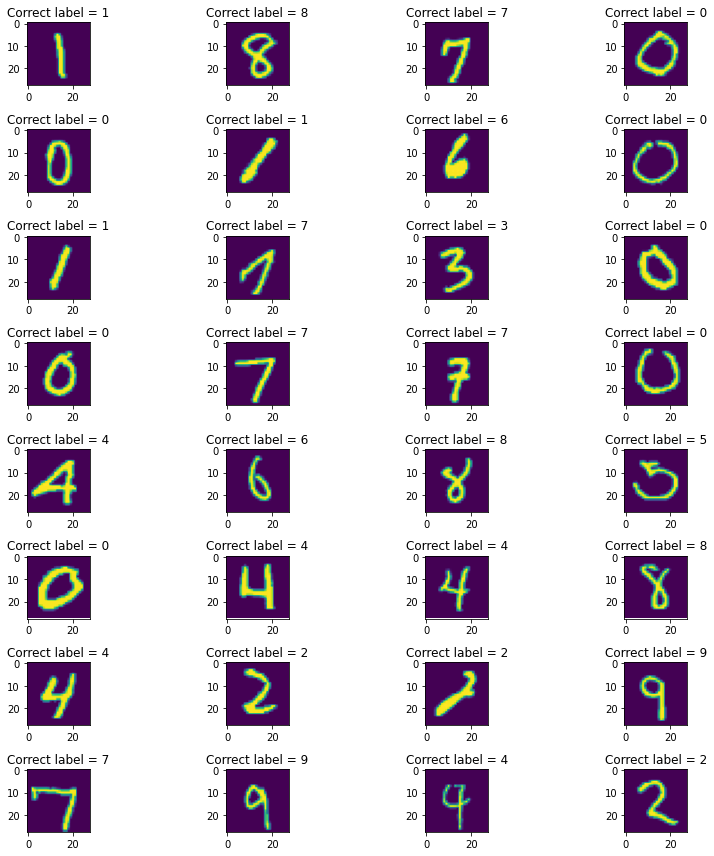

In [95]:
rows = 8
columns = 4

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(12,12))

for i in range(rows):
    for j in range(columns):   
        curr_idx = i*columns+j
        curr_img = images[curr_idx].permute(1,2,0)
        curr_label = labels[curr_idx].item()
        axes[i,j].title.set_text(f'Correct label = {curr_label}')
        axes[i, j].imshow(curr_img)
fig.set_tight_layout(True)

### Build models

In [110]:
class MyConvNet(nn.Module):
    def __init__(self, image_size, num_filters1, num_filters2, lin_width1, linwidth2):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, self.num_filters1, kernel_size=3)
        self.conv2 = nn.Conv2d(self.num_filters1, self.num_filters2, kernel_size=3)
        self.fc1 = nn.Linear((self.image_size-4)*num_filters2, self.lin_width2)
        self.fc2 = nn.Linear(self.lin_width2, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = einops.rearrange(x, 'b c x y -> b (c x y)')
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x)